## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
import pydot as pyd
from itertools import chain
from tqdm.notebook import tqdm

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [5]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [6]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [7]:
decoder_disc_data = decoder_target_data[:,0,0:1]
decoder_disc_data[:,:] = 1
decoder_disc_data.shape

(4368, 1)

In [8]:
decoder_input_data_rand = None
for _ in tqdm(range(decoder_input_data.shape[0])):
    a = np.expand_dims(np.eye(decoder_input_data.shape[1], decoder_input_data.shape[2]), axis=0)
    if decoder_input_data_rand is None:
        decoder_input_data_rand = a
    else:
        decoder_input_data_rand = np.append(decoder_input_data_rand, a, axis=0)
decoder_input_data_rand.shape

  0%|          | 0/4368 [00:00<?, ?it/s]

(4368, 3822, 4)

In [9]:
decoder_disc_data_rand = decoder_input_data_rand[:,0,0:1]
decoder_disc_data_rand[:,:] = 0
decoder_disc_data_rand.shape

(4368, 1)

In [10]:
X1 = np.append(encoder_input_data, encoder_input_data, axis=0)
X2 = np.append(decoder_input_data, decoder_input_data_rand, axis=0)
Y  = np.append(decoder_disc_data, decoder_disc_data_rand, axis=0)

p = np.random.permutation(len(Y))
X1, X2, Y = X1[p], X2[p], Y[p]

In [24]:
n = 20
X1_data = X1[:n]
X2_data = X2[:n]
Y_data  = Y[:n]
print("X1_data", X1_data.shape)
print("X2_data", X2_data.shape)
print("Y_data", Y_data.shape)

X1_data (20, 3822, 4)
X2_data (20, 3822, 4)
Y_data (20, 1)


## Construct model

In [25]:
n_hidden = 32

In [26]:
input_train = Input(shape=(X1_data.shape[1], X1_data.shape[2]))
output_train = Input(shape=(X2_data.shape[1], X2_data.shape[2]))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")


In [27]:
encoder_stack_h, encoder_last_h = GRU(
    n_hidden, dropout = 0.05, recurrent_dropout = 0.05,
    return_sequences = True, return_state = True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 32), dtype=tf.float32, name=None), name='gru_2/transpose_1:0', description="created by layer 'gru_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gru_2/while:4', description="created by layer 'gru_2'")


In [28]:
encoder_last_h = BatchNormalization(momentum = 0.6)(encoder_last_h)
decoder_input = RepeatVector(X2_data.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 32), dtype=tf.float32, name=None), name='repeat_vector_1/Tile:0', description="created by layer 'repeat_vector_1'")


In [29]:
decoder_stack_h = GRU(n_hidden, dropout = 0.01, recurrent_dropout = 0.01,
 return_state = False, return_sequences = True)(
 decoder_input, initial_state = encoder_last_h)
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 32), dtype=tf.float32, name=None), name='gru_3/transpose_1:0', description="created by layer 'gru_3'")


In [30]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 3822), dtype=tf.float32, name=None), name='activation_1/Softmax:0', description="created by layer 'activation_1'")


In [31]:
context = dot([attention, encoder_stack_h], axes = [2,1])
context = BatchNormalization(momentum = 0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 32), dtype=tf.float32, name=None), name='batch_normalization_3/batchnorm/add_1:0', description="created by layer 'batch_normalization_3'")


In [32]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 64), dtype=tf.float32, name=None), name='concatenate_2/concat:0', description="created by layer 'concatenate_2'")


In [33]:
mutation_out = TimeDistributed(Dense(X1_data.shape[2], activation = "softmax"))(decoder_combined_context)
print(mutation_out)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


In [35]:
discriminator_input = keras.layers.concatenate([output_train, mutation_out])
discriminator_input = keras.layers.Flatten()(discriminator_input)
discriminator = keras.layers.Dense(1024, activation = "tanh")
discriminator = discriminator(discriminator_input)
disc_output = keras.layers.Dense(1, activation = "sigmoid")(discriminator)
print(disc_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")


In [36]:
model = Model(inputs = [input_train, output_train], outputs = disc_output)
opt = keras.optimizers.Adam(learning_rate = 0.01, clipnorm = 1)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 3822, 4)]    0           []                               
                                                                                                  
 gru_2 (GRU)                    [(None, 3822, 32),   3648        ['input_4[0][0]']                
                                 (None, 32)]                                                      
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 32)          128         ['gru_2[0][1]']                  
 rmalization)                                                                                     
                                                                                              

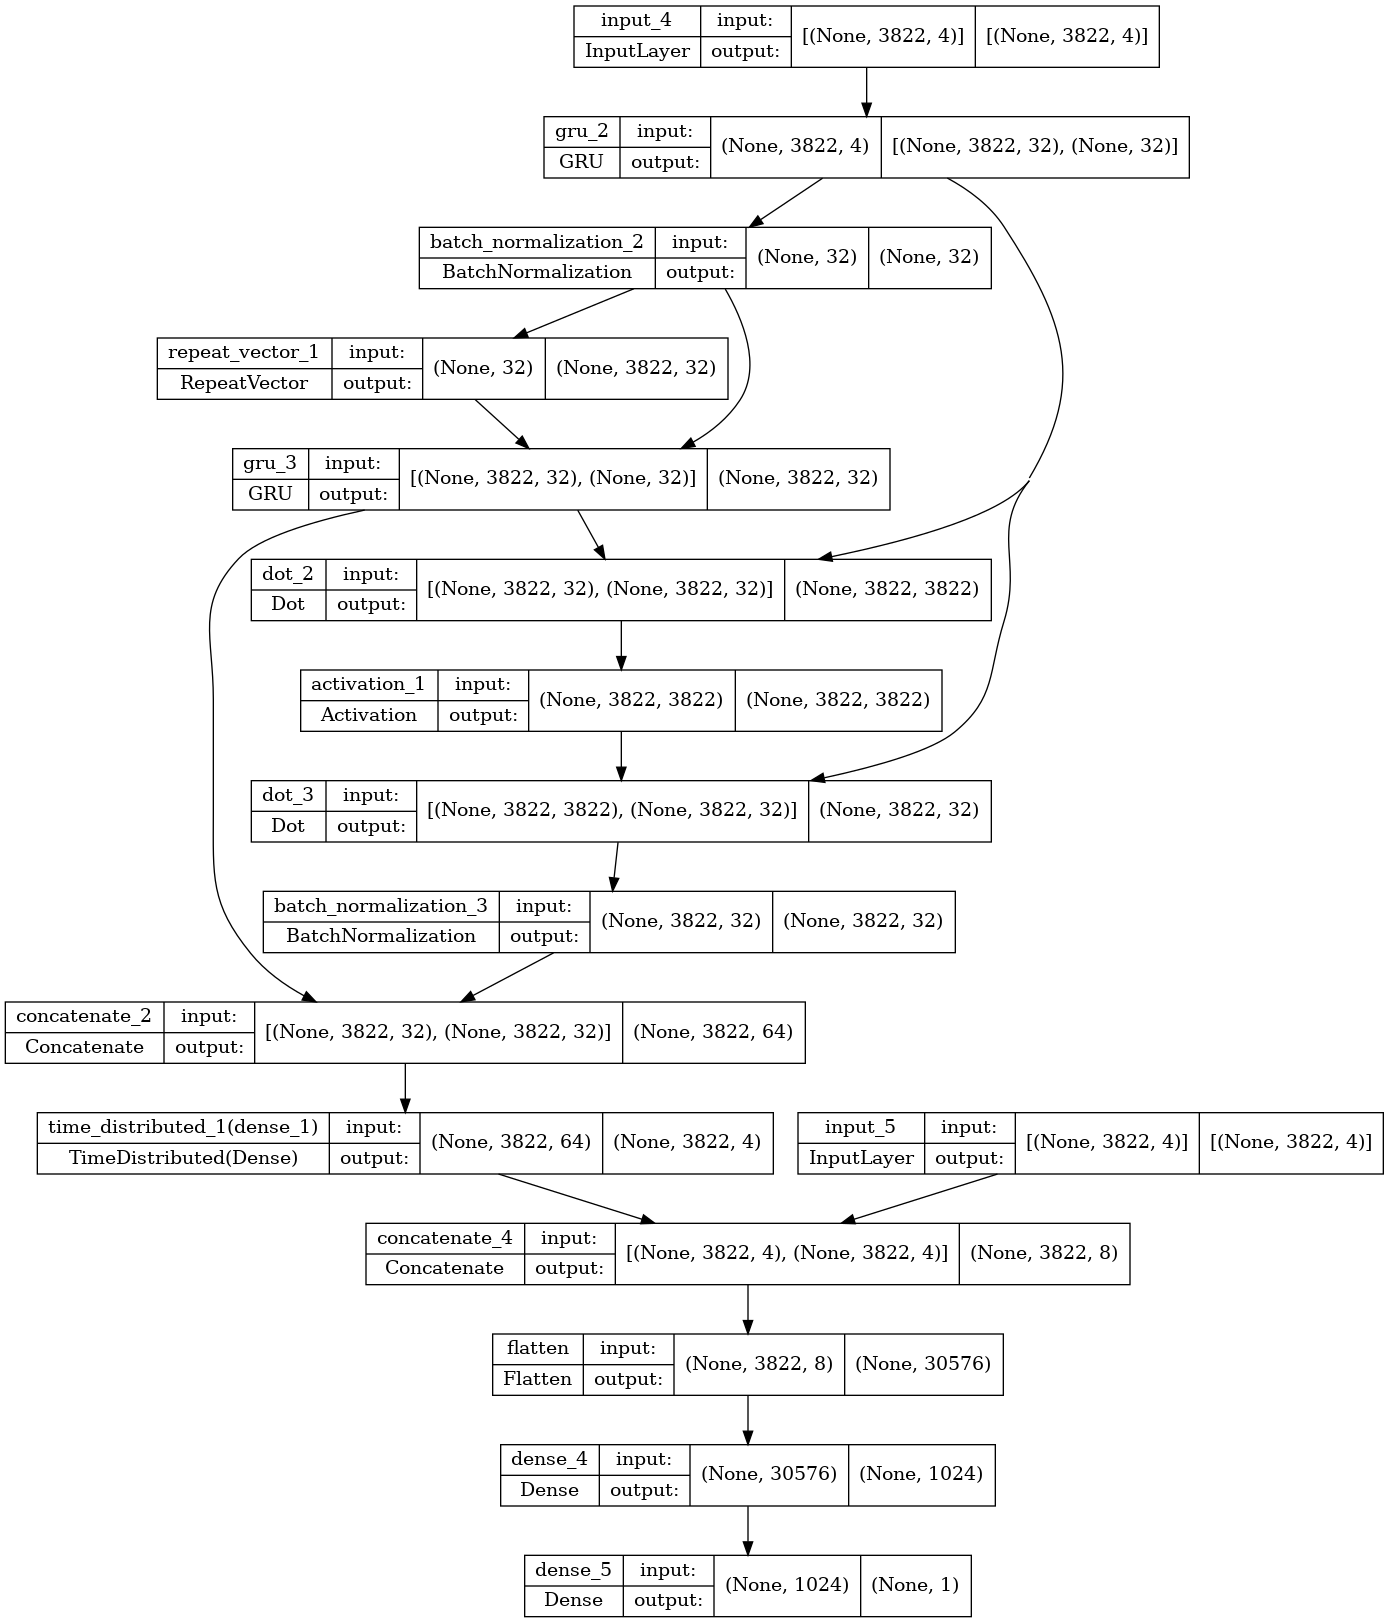

In [37]:
keras.utils.plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

## Train model

In [38]:
batch_size = 16      # Batch size for training.
patience = 10        # Patience for EarlyStop
epochs = 100         # Number of epochs to train for.

In [39]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit(X_data, Y_data, validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)
train_mae = history.history['accuracy']
valid_mae = history.history['val_accuracy']

Epoch 1/100
1/1 [==============================] - 12s 12s/step - loss: 0.0000e+00 - accuracy: 0.2500 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.7500 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.7500 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.7500 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.7500 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.7500 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 8s 8s/step - loss: 0.0000e+00 - accuracy: 0.750

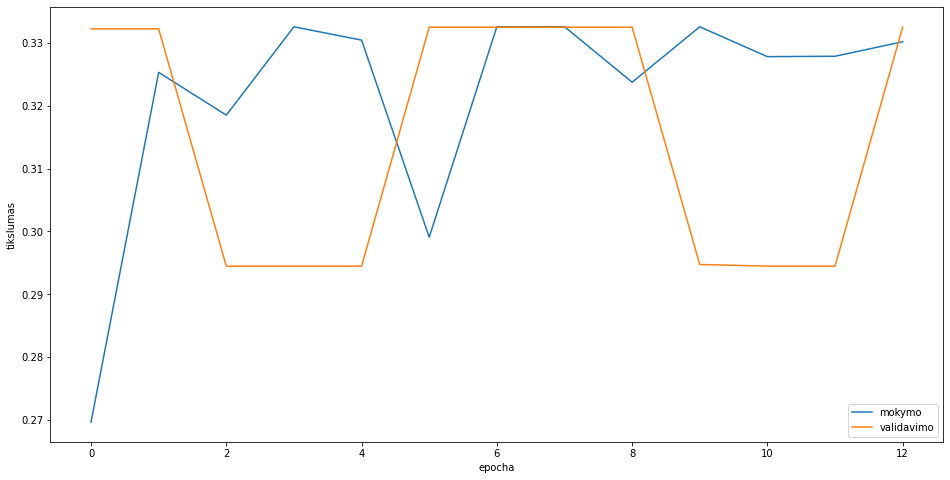

In [21]:
plt.plot(history.history['accuracy'], label = 'mokymo')
plt.plot(history.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

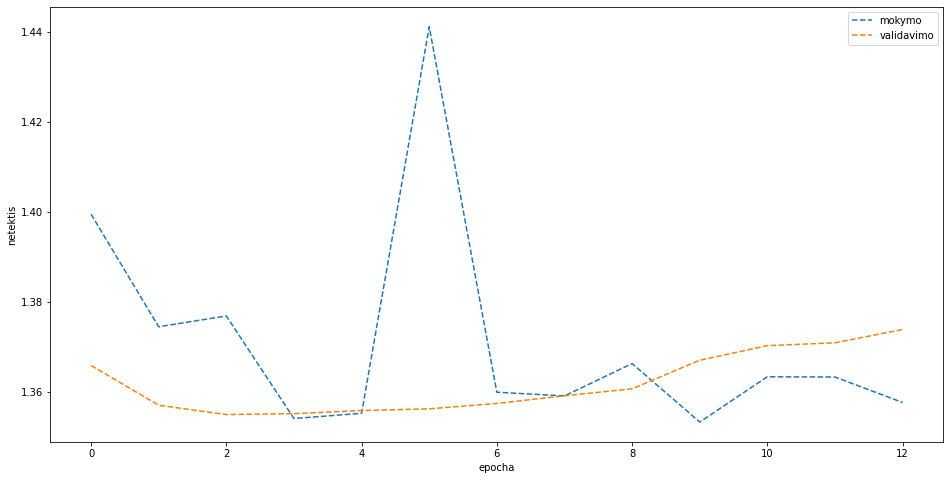

In [22]:
plt.plot(history.history['loss'], '--', label = 'mokymo')
plt.plot(history.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [14]:
model.save("data/ncbi_02/model_gru_bi_256")

2021-10-07 10:59:42.345759: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_bi_256/assets


INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_bi_256/assets
